# Cross-validation of embedding methods

Perform cross-validation of an embedding method to tune hyperparameters and evaluate the accuracy of classifications based on Euclidean distances of embedded space.

## Analysis outline

1. Load genome sequences from a FASTA file
1. Load clade membership annotations for each genome from a separate metadata file
1. Calculate a pairwise distance matrix from the genome sequences.
1. For each fold in a *k-fold* analysis
  1. Identify sequences in the fold
  1. Subset the distance matrix to only those sequences in the fold
  1. Apply the current embedding method (e.g., MDS, t-SNE, UMAP) to the distance matrix
  1. Calculate the pairwise Euclidean distance between sequences in the embedding
  1. Calculate and store the Pearson's correlation between genetic and Euclidean distances for all pairs in the embedding
  1. Calculate and store a distance threshold below which any pair of sequences are assigned to the same clade
  1. Apply the current embeddng method to the subset of the distance matrix corresponding to the validation data for the current fold
  1. Calculate the pairwise Euclidean distance between sequences in the validation embedding
  1. Assign all pairs of sequences in the validation set to estimated "within" or "between" clade statuses based on their distances
  1. Calculate the confusion matrix from the estimated and observed clade identities
  1. Calculate and store accuracy, Matthew's correlation coefficient, etc. from the confusion matrix
1. Plot the distribution of Pearson's correlations across all *k* folds
1. Plot the distribution of accuracies, etc. across all *k* folds

## Define inputs, outputs, and parameters

In [1]:
sequences_path = "../seasonal-flu-nextstrain/results-20162018/aligned.fasta"
clades_path = "../seasonal-flu-nextstrain/results-20162018/clades.json"

## Imports

In [2]:
from augur.utils import read_node_data
import Bio.SeqIO
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import statsmodels
import statistics
from umap import UMAP

from Helpers import get_hamming_distances, get_euclidean_data_frame, scatterplot_xyvalues

%matplotlib inline

In [3]:
def assign_clade_status_to_pairs(clade_annotations, index):
    """Assign clade status to all pairs in the given list of indices and the given data frame of clade annotations.
    
    Outputs a vector in condensed distance matrix format such that all nonredundant pairs of strains are represented.
    
    """
    clade_statuses = []
    for i in range(len(index)):
        for j in range(i + 1, len(index)):
            same_clade = clade_annotations.loc[index[i], "clade"] == clade_annotations.loc[index[j], "clade"]
            clade_statuses.append(int(same_clade))
            
    return np.array(clade_statuses)

## Load clade membership annotations

In [4]:
node_data = read_node_data(clades_path)

## Load genome sequences

In [5]:
sequences_by_name = OrderedDict()

for sequence in Bio.SeqIO.parse(sequences_path, "fasta"):
    if sequence.id in node_data["nodes"]:
        sequences_by_name[sequence.id] = str(sequence.seq)
    
sequence_names = list(sequences_by_name.keys())

In [6]:
sequence_names[:5]

['A/Alabama/02/2016',
 'A/Alaska/23/2016',
 'A/SouthAustralia/148/2016',
 'A/California/111/2016',
 'A/Hawaii/55/2016']

In [7]:
len(sequence_names)

1164

In [8]:
# Build a data frame of clade annotations per strain in the same order
# as the sequences and the subsequent distance matrix.
clade_annotations = pd.DataFrame([
    {"strain": sequence_name, "clade": node_data["nodes"][sequence_name]["clade_membership"]}
    for sequence_name in sequence_names
])

In [9]:
len(clade_annotations)

1164

In [10]:
clade_annotations.head()

,strain,clade
0,A/Alabama/02/2016,3c2.A
1,A/Alaska/23/2016,3c2.A
2,A/SouthAustralia/148/2016,3c2.A
3,A/California/111/2016,3c2.A
4,A/Hawaii/55/2016,3c2.A


## Calculate distance matrix

In [11]:
hamming_distances = get_hamming_distances(
    sequences_by_name.values()
)
distance_matrix = squareform(hamming_distances)

In [12]:
distance_matrix.shape

(1164, 1164)

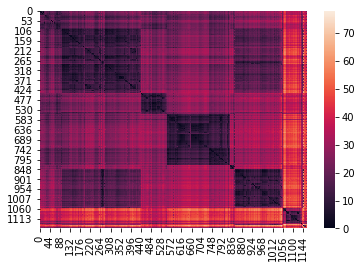

In [13]:
sns.heatmap(distance_matrix)

## Assign sequences to k-fold groups and analyze each fold

For each fold, use the training indices to subset the distance matrix to just those columns and rows that belong in the training data. Apply a given embedding method to the distance matrix subset, identify the classification threshold for clade membership, and validate that threshold on the subset of the distance matrix corresponding to the validation indices.

In [16]:
# TODO: In practice we will want to iterate over all combinations of parameters
# for all embedding methods and also support PCA (which does not use a distance matrix as input).
embedding_class = TSNE
embedding_parameters = {
    "metric": "precomputed",
    "perplexity": 30,
    "learning_rate": 500.0
}
tuned_parameters = [{
    "metric": "precomputed",
    "perplexity": [15, 20, 25, 30, 100],
    "learning_rate": [100.0, 200.0, 300.0, 400.0, 500.0, 1000.0]
}]

In [15]:
embedding_class = UMAP
embedding_parameters = {
    "n_neighbors": 20,
    "min_dist": 0.5,
    "n_components": 2,
    "init": "spectral"
}

In [17]:
embedding_class = MDS
embedding_parameters = {
    "dissimilarity": "precomputed"
}

In [18]:
fold_factory = KFold(n_splits=5, shuffle=True)
folds = fold_factory.split(sequence_names)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [ ]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)


In [ ]:
# TODO: consider adding support for an exhaustive grid search of parameters 
# for different embeddings and the classifier:
# https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search
genetic_accuracies = []
accuracies = []
classifier_thresholds = []
confusion_matrices = []
matthews_cc = []
for k, (training_index, validation_index) in enumerate(folds): 
    print(f"Fit to fold: {k}")
    # Subset distance matrix to training indices.
    training_distance_matrix = distance_matrix[training_index][:, training_index]
    
    # Embed training distance matrix.
    embedder = embedding_class(**embedding_parameters)
    training_embedding = embedder.fit_transform(training_distance_matrix)
    
    # Calculate Euclidean distance between pairs of samples in the embedding.
    # The output is a condensed distance matrix with distances between pairs.
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    training_embedding_distances = pdist(training_embedding).reshape(-1, 1)
    
    # Assign a binary class to each pair of samples based on their clade memberships.
    # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
    # This vector of binary values will be the output to fit a classifier to.
    # These pairs should be in the same order as the embedding distances above.
    training_clade_status_for_pairs = assign_clade_status_to_pairs(
        clade_annotations,
        training_index
    )
    
    # Use a support vector machine classifier to identify an optimal threshold
    # to distinguish between within and between class pairs.
    # See also: https://scikit-learn.org/stable/modules/svm.html#svm-classification
    classifier = make_pipeline(
        StandardScaler(),
        LinearSVC(random_state=0, tol=1e-5)
    )
    
    classifier.fit(training_embedding_distances, training_clade_status_for_pairs)
    
    classifier_threshold = (0.5 - classifier.named_steps["linearsvc"].intercept_) / classifier.named_steps["linearsvc"].coef_[0]
    classifier_thresholds.append(classifier_threshold)
    
    # Use a SVM to identify an optimal threshold for genetic distances.
    genetic_classifier = make_pipeline(
        StandardScaler(),
        LinearSVC(random_state=0, tol=1e-5)
    )
    genetic_classifier.fit(squareform(training_distance_matrix).reshape(-1, 1), training_clade_status_for_pairs)
    
    # Subset distance matrix to validation indices.
    validation_distance_matrix = distance_matrix[validation_index][:, validation_index]
    
    # Embed validation distance matrix.
    validation_embedding = embedder.fit_transform(validation_distance_matrix)
    
    # Calculate Euclidean distance between pairs of samples in the embedding.
    # The output should be a data frame of distances between pairs.
    validation_embedding_distances = pdist(validation_embedding).reshape(-1, 1)
    
    # Assign a binary class to each pair of samples based on their clade memberships.
    # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
    # This vector of binary values will be the output to fit a classifier to.
    # These pairs should be in the same order as the embedding distances above.
    validation_clade_status_for_pairs = assign_clade_status_to_pairs(
        clade_annotations,
        validation_index
    )

    # Predict and score clade status from embedding distances and the trained classifier.
    # The first argument is the set to predict classifier labels for. The second argument
    # is the list of true labels. The return argument is the mean accuracy of the predicted
    # labels.
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.score
    confusion_matrices.append(confusion_matrix(classifier.predict(validation_embedding_distances), validation_clade_status_for_pairs))
    matthews_cc.append(matthews_corrcoef(classifier.predict(validation_embedding_distances), validation_clade_status_for_pairs))
    
    accuracy = classifier.score(
        validation_embedding_distances,
        validation_clade_status_for_pairs
    )
    print(f"Accuracy: {accuracy}")
    
    genetic_accuracy = genetic_classifier.score(
        squareform(validation_distance_matrix).reshape(-1, 1),
        validation_clade_status_for_pairs
    )
    print(f"Genetic accuracy: {genetic_accuracy}")
    print()
    
    accuracies.append(accuracy)
    genetic_accuracies.append(genetic_accuracy)

In [36]:
# embedding parameters will be set within the script itself. This code will be creating the distribution (gives list of r values), and the scatterplot script will also return
# a dataframe containing the xy values of the scatterplot (full) for whatever embedding is passed in.
def scatterplot_distribution(distance_matrix, name_of_embedding):
    fold_factory = KFold(n_splits=5, shuffle=True)
    folds = fold_factory.split(sequence_names)
    r_value_array = []
    for k, (training_index, validation_index) in enumerate(folds): 
        validation_distance_matrix = distance_matrix[validation_index][:, validation_index]
        validation_strains = np.take(sequence_names, validation_index)
        validation_strains_df = pd.DataFrame(validation_strains, columns = ["strain"])
        clade_and_validation = clade_annotations.merge(validation_strains_df, on="strain")
        # Embed training distance matrix.
        embedder = embedding_class(**embedding_parameters)
        validation_embedding = embedder.fit_transform(validation_distance_matrix)
        if name_of_embedding == "pca" or name_of_embedding == "mds":
            validation_embedding_df = pd.DataFrame(validation_embedding, columns=[name_of_embedding + str(i) for i in range(1,embedding_parameters["n_components"] + 1)])
        else:
            validation_embedding_df = pd.DataFrame(validation_embedding, columns=[name_of_embedding + str(1), name_of_embedding + str(2)])
            
        validation_embedding_df["strain"] = validation_strains
        #validation_embedding_df = validation_embedding_df.merge(clade_and_validation, on="strain")
        total_df = scatterplot_xyvalues(validation_strains, validation_distance_matrix, validation_embedding_df, name_of_embedding + str(1), name_of_embedding + str(2), name_of_embedding)
        
        y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
        total_df["euclidean"],
        total_df["genetic"],
        frac=0.6666666666666666,
        it=3,
        delta=0.0,
        is_sorted=False,
        missing='drop',
        return_sorted=True
        )

        PD_Y_values = pd.DataFrame(y_values)
        PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]
        regression = linregress(total_df["genetic"], total_df["euclidean"])
        slope, intercept, r_value, p_value, std_err = regression

        r_value_array.append(r_value ** 2)

    return r_value_array

In [37]:
r_value_array = scatterplot_distribution(distance_matrix, "TSNE")

[Text(0.5,1,'TSNE distribution')]

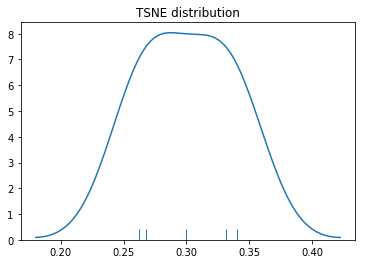

In [38]:
sns.distplot(r_value_array, hist=False, rug=True).set(title = "TSNE distribution")

In [19]:
    total_df = scatterplot_xyvalues(validation_strains, validation_distance_matrix, validation_embedding_df, "TSNE1", "TSNE2", "TSNE")
    y_values = statsmodels.nonparametric.smoothers_lowess.lowess(
    total_df["euclidean"],
    total_df["genetic"],
    frac=0.6666666666666666,
    it=3,
    delta=0.0,
    is_sorted=False,
    missing='drop',
    return_sorted=True
    )

    PD_Y_values = pd.DataFrame(y_values)
    PD_Y_values.columns = ["LOWESS_x", "LOWESS_y"]

In [ ]:

regression = linregress(total_df["genetic"], total_df["euclidean"])
slope, intercept, r_value, p_value, std_err = regression

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df["genetic"], total_df["euclidean"], "o", alpha=0.25)
ax.plot(PD_Y_values["LOWESS_x"], PD_Y_values["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (r_value ** 2))

sns.despine()
plt.savefig("docs/PCAScatterplotLOESS" + virus_name + ".png")

In [ ]:
sns.heatmap(confusion_matrices[3], annot=True)

In [ ]:
training_embedding_df = pd.DataFrame(training_embedding, columns=["x", "y"])
training_embedding_df["clade"] = clade_annotations.loc[training_index, "clade"].values

In [ ]:
validation_embedding_df = pd.DataFrame(validation_embedding, columns=["x", "y"])
validation_embedding_df["clade"] = clade_annotations.loc[validation_index, "clade"].values

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot("x", "y", hue="clade", data=training_embedding_df, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("x", "y", hue="clade", data=validation_embedding_df, legend=False, ax=axes[1])
axes[1].set_title("Validation")

sns.despine()

In [ ]:
training_embedding_distances.shape

In [ ]:
training_clade_status_for_pairs.shape

In [ ]:
training_embedding_distances.flatten()

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit_transform(training_embedding_distances)

In [ ]:
distances_df = pd.DataFrame({"distance": training_embedding_distances.flatten(), "same_clade": training_clade_status_for_pairs.flatten()})

In [ ]:
distances_df.head()

In [ ]:
distances_df["scaled_distance"] = scaler.fit_transform(training_embedding_distances).flatten()

In [ ]:
distances_df["genetic_distance"] = squareform(training_distance_matrix)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax = sns.kdeplot(distances_df.query("same_clade == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(distances_df.query("same_clade == 0")["scaled_distance"], label="Different clade", ax=ax)

for classifier_threshold in classifier_thresholds:
    ax.axvline(x=classifier_threshold, label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

ax = axes[1]
ax = sns.kdeplot(distances_df.query("same_clade == 1")["genetic_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(distances_df.query("same_clade == 0")["genetic_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Genetic distance")
ax.set_ylabel("KDE density")

sns.despine()

## Plot and summarize accuracies

In [ ]:
# Print the mean accuracy and stddev
print(f"Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bins = np.arange(0, 1.01, 0.05)

ax.hist(accuracies, bins=bins)

ax.axvline(
    x=np.mean(accuracies),
    label=f"Mean accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}",
    color="orange"
)

ax.set_xlabel("Accuracy of classifier")
ax.set_ylabel("Number of cross-validation folds")

ax.legend(frameon=False)

sns.despine()

## Plot classifier thresholds

The linear support vector classifier (SVC) produces an intercept and coefficient for a single feature that represents a line through the domain of the input data that classifies samples into "same clade" (1) or "different clade" (0). The midpoint between these classification labels (0.5) is useful for visualizing the placement of the SVC results. We calculate the value of the input domain that corresponds to this line by solving for $0.5 = mx + b$ where $x$ is the value of interest from the input domain.

Below we plot the resulting distribution of classifier thresholds across all *k* folds to get a sense of how consistent these values are across training sets. Note that the input data have been scaled to z-values (centered by their mean and divided by their standard deviation).

In [ ]:
classifier_thresholds = np.array(classifier_thresholds).flatten()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(classifier_thresholds.flatten(), bins=10)

ax.axvline(
    x=np.mean(classifier_thresholds),
    label=f"Mean classifier threshold: {np.mean(classifier_thresholds):.2f} +/- {np.std(classifier_thresholds):.2f}",
    color="orange"
)

ax.set_xlabel("Classifier threshold on scaled Euclidean distances")
ax.set_ylabel("Number of cross-validation folds")

ax.legend(frameon=False)

sns.despine()